<a href="https://colab.research.google.com/github/twelvesense/first-repository/blob/master/ExplNode04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# 1. 데이터 살펴보기

File descriptions

    train.csv - 예측 모델을 만들기 위해 사용하는 학습 데이터입니다. 집의 정보와 예측할 변수인 가격(Price) 변수를 가지고 있습니다.
    test.csv - 학습셋으로 만든 모델을 가지고 예측할 가격(Price) 변수를 제외한 집의 정보가 담긴 테스트 데이터 입니다.
    sample_submission.csv - 제출시 사용할 수 있는 예시 submission.csv 파일입니다.

Data fields

    ID : 집을 구분하는 번호
    date : 집을 구매한 날짜
    price : 집의 가격(Target variable)
    bedrooms : 침실의 수
    bathrooms : 화장실의 수
    sqft_living : 주거 공간의 평방 피트(면적)
    sqft_lot : 부지의 평방 피트(면적)
    floors : 집의 층 수
    waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
    view : 집이 얼마나 좋아 보이는지의 정도
    condition : 집의 전반적인 상태
    grade : King County grading 시스템 기준으로 매긴 집의 등급
    sqft_above : 지하실을 제외한 평방 피트(면적)
    sqft_basement : 지하실의 평방 피트(면적)
    yr_built : 지어진 년도
    yr_renovated : 집을 재건축한 년도
    zipcode : 우편번호
    lat : 위도
    long : 경도
    sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
    sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)


In [150]:
train_data_path = 'https://raw.githubusercontent.com/twelvesense/first-repository/master/input/train.csv'
test_data_path = 'https://raw.githubusercontent.com/twelvesense/first-repository/master/input/test.csv'

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [151]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [152]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


# 2. EDA

### 2-1. 결측치 확인하기

##### ■ 그래픽한 방법으로 확인하기

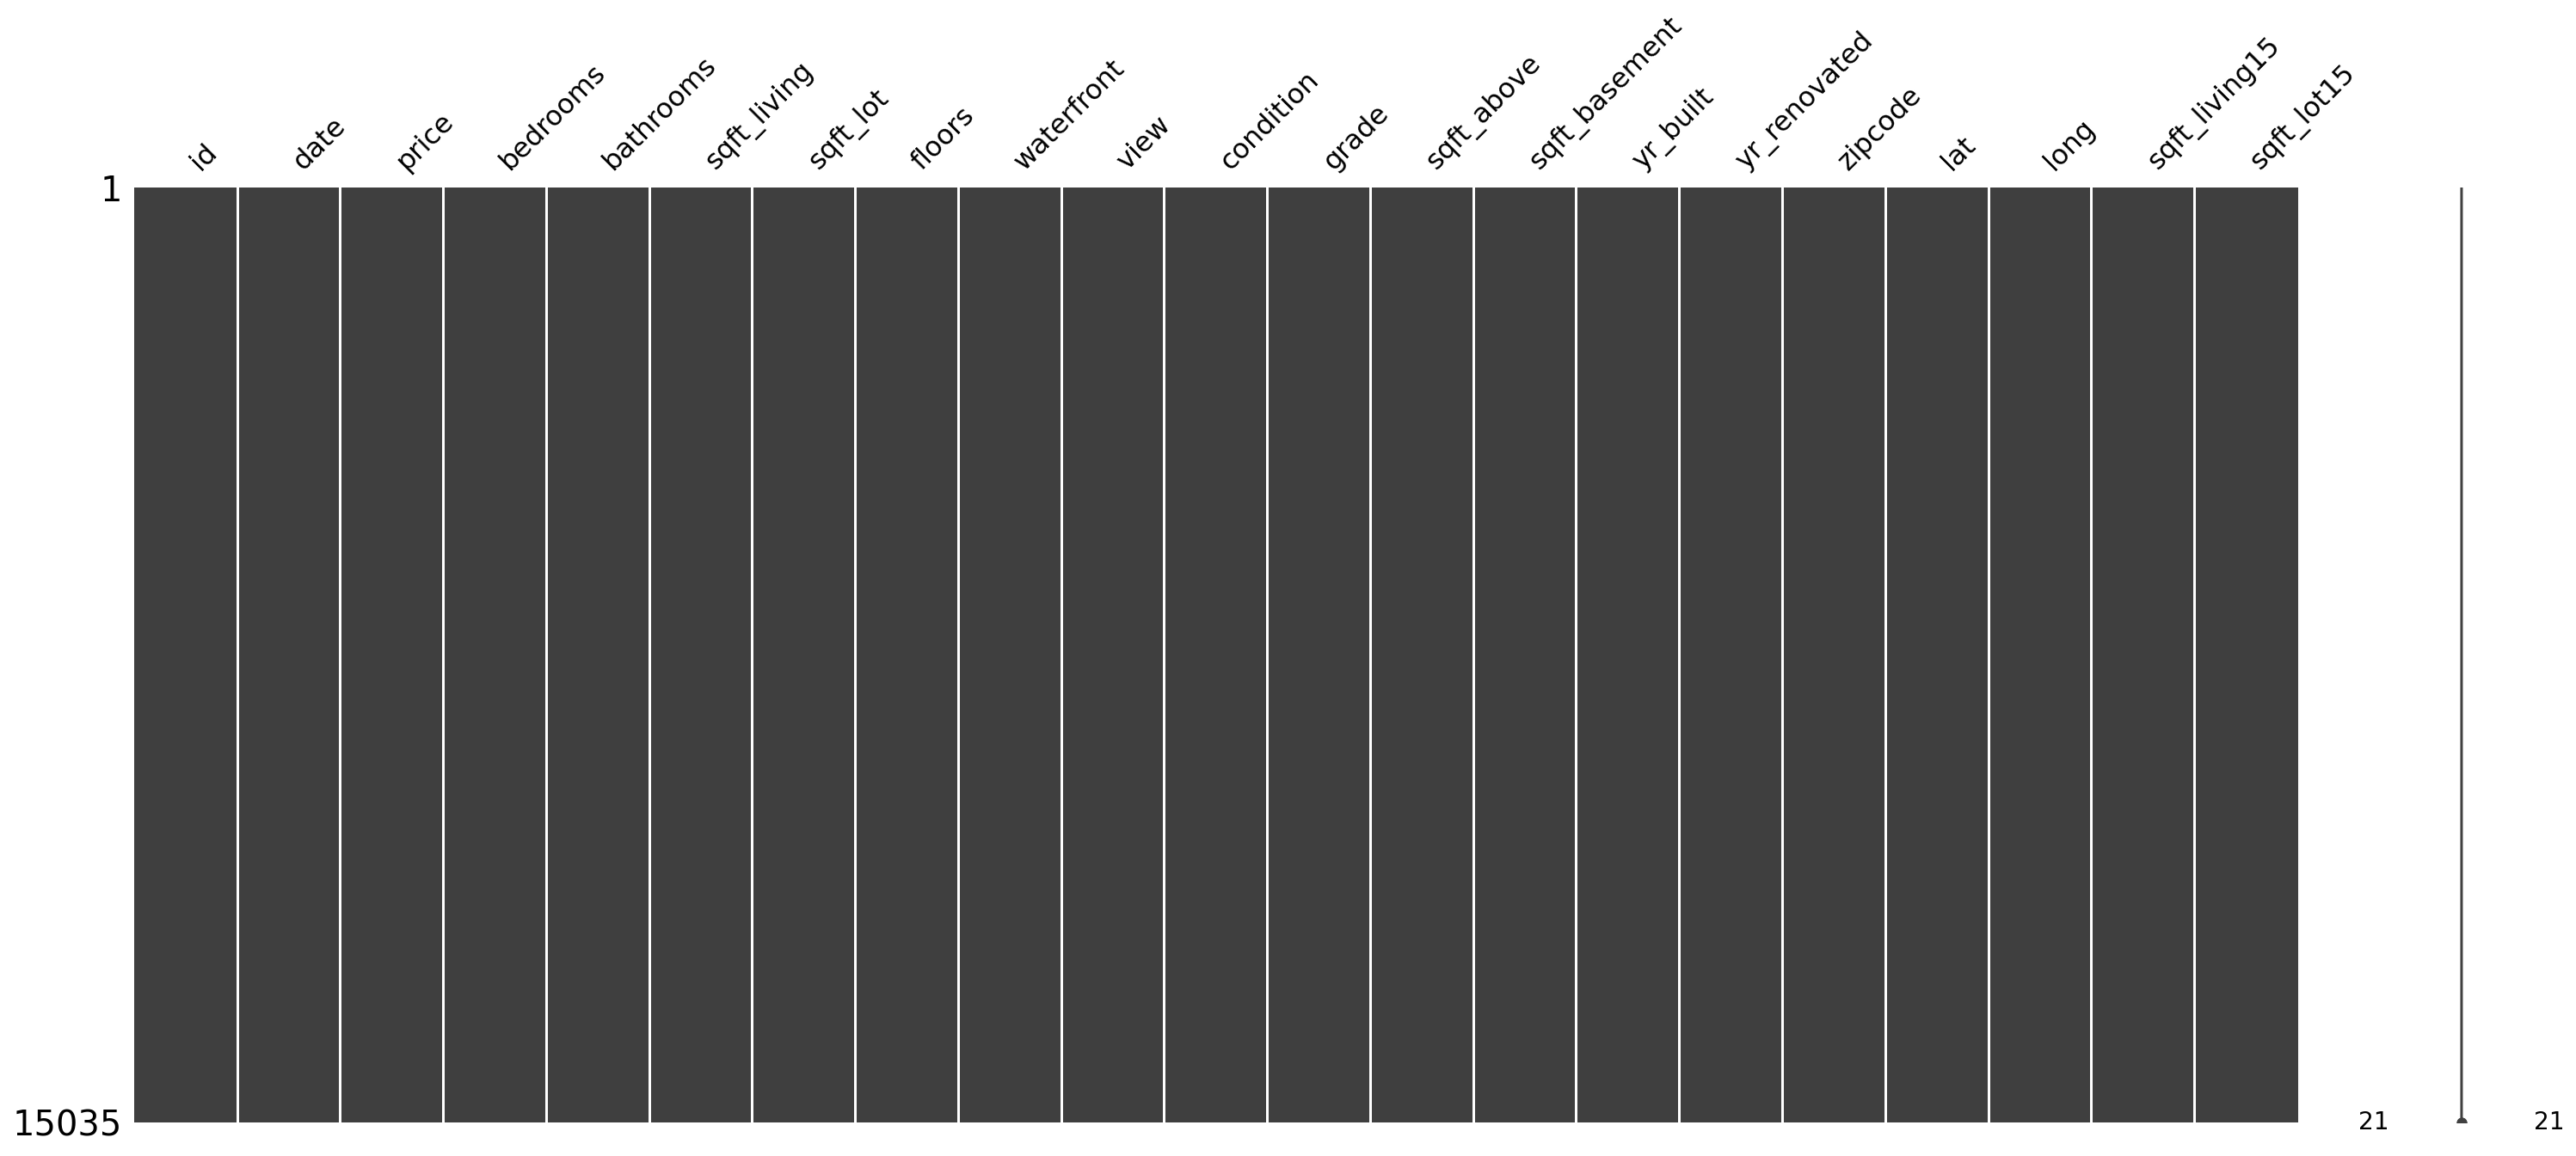

In [153]:
msno.matrix(train)

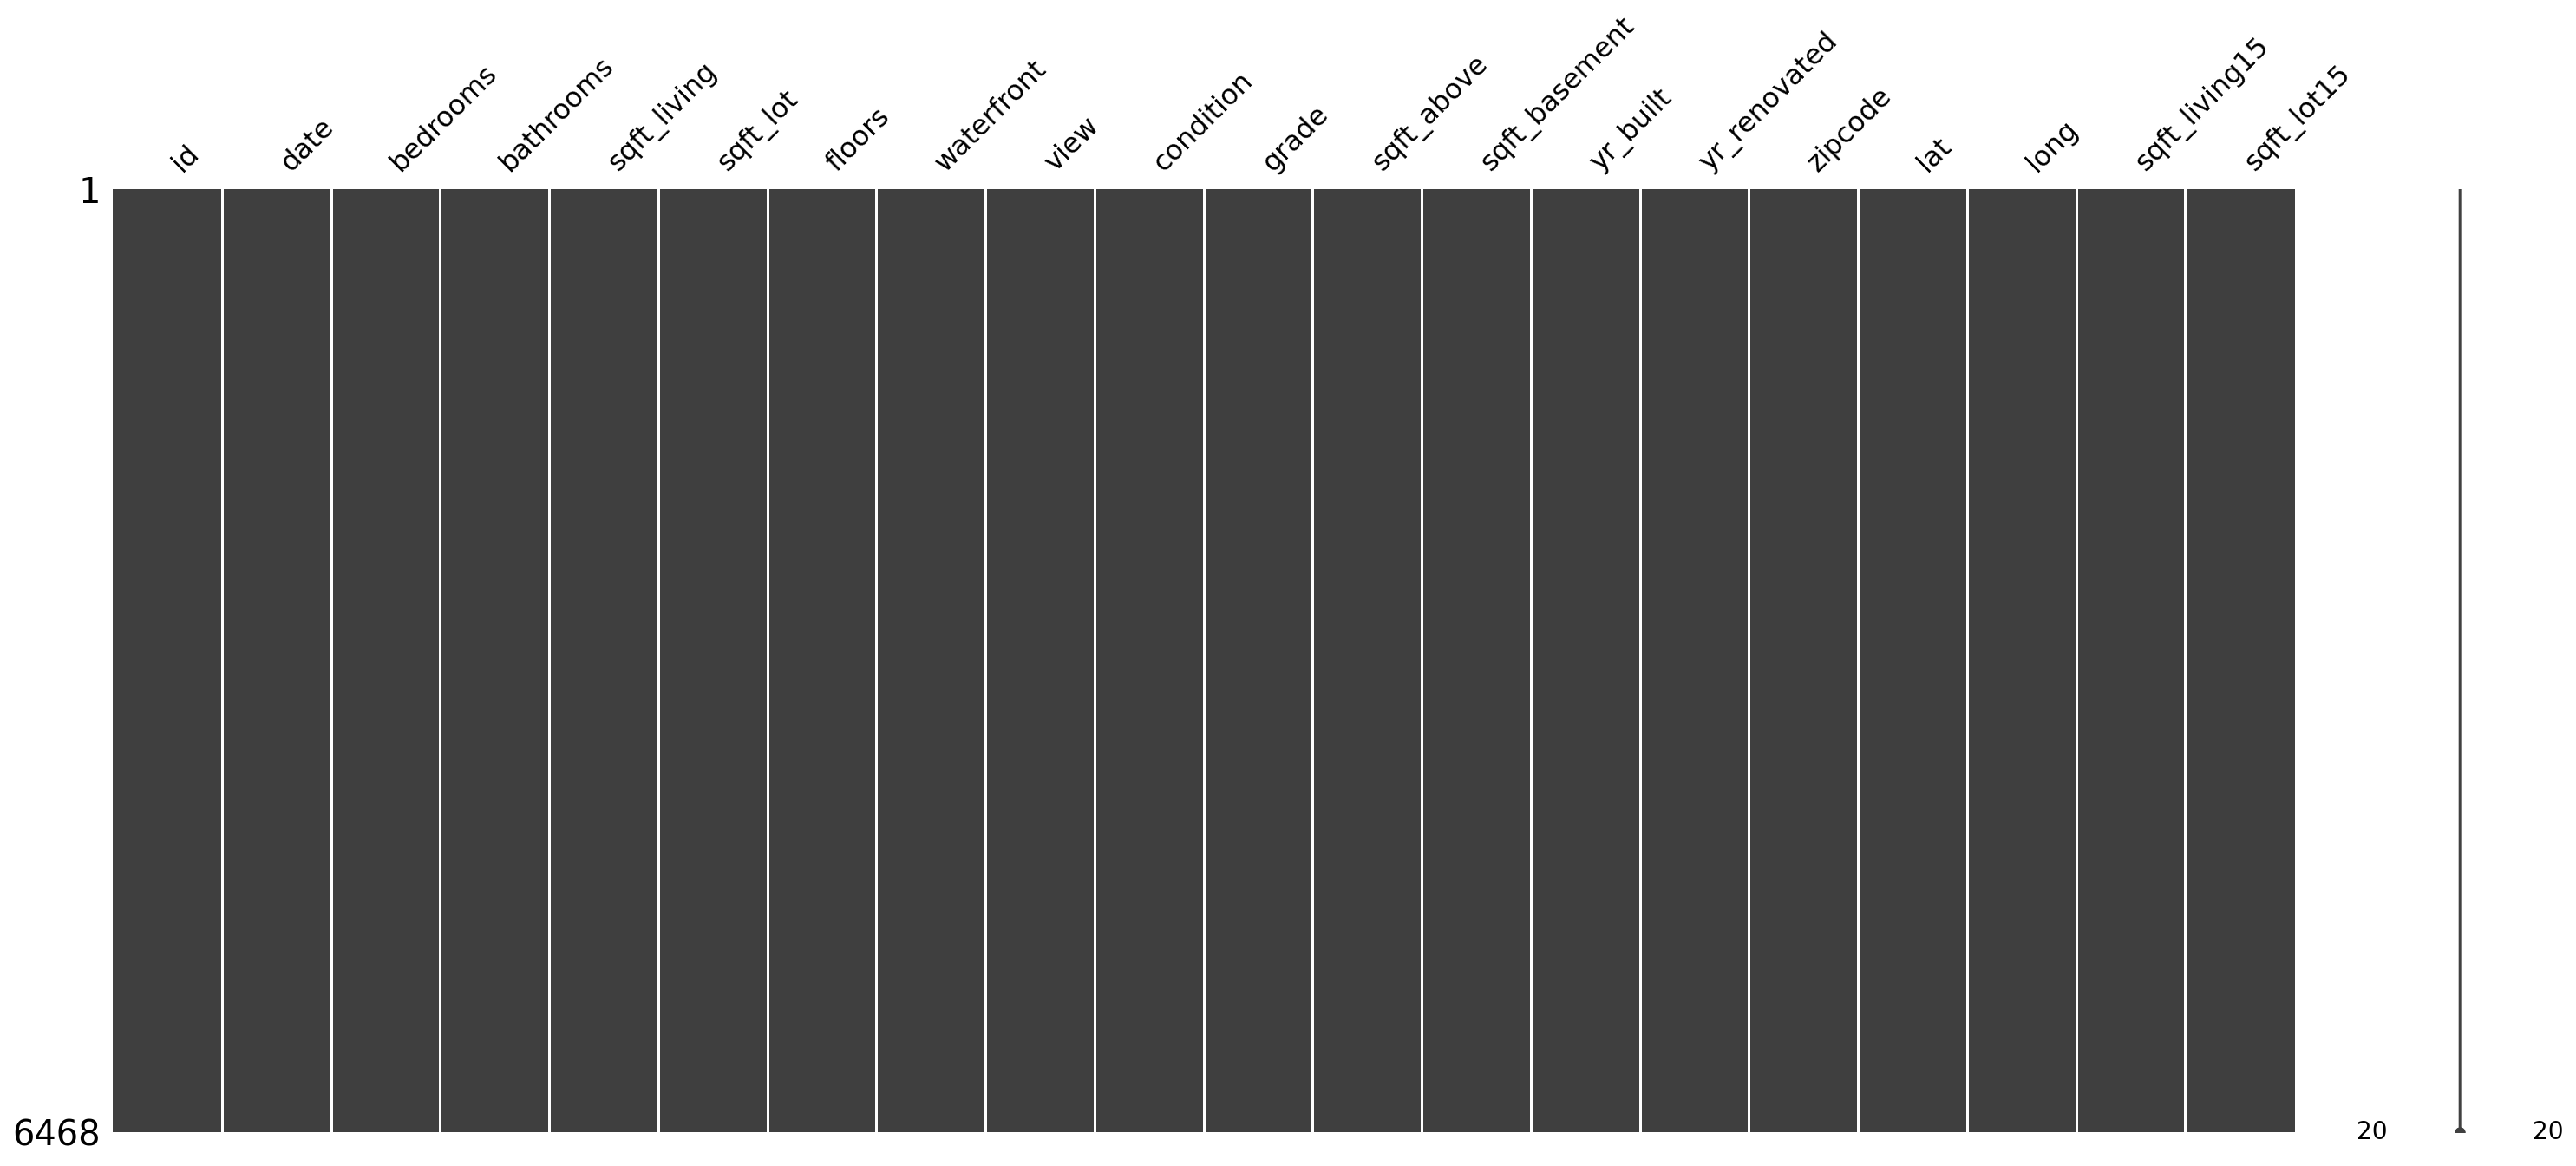

In [154]:
msno.matrix(test)

##### ■ 문자적인 방법으로 확인하기

In [155]:
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [156]:
for c in test.columns:
    print('{} : {}'.format(c, len(test.loc[pd.isnull(test[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 2-2. 피처 엔지니어링: 불필요한 피처 정리 및 피처의 적절한 수정

##### ■ train, test의 요소 중, 불필요한 id 열은 삭제하고, date 열의 값은 6자리로 잘라준다.

In [157]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
del train['id']
print(train.columns)
train.head()

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [158]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']
print(test.columns)
test.head()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


##### ■상관관계

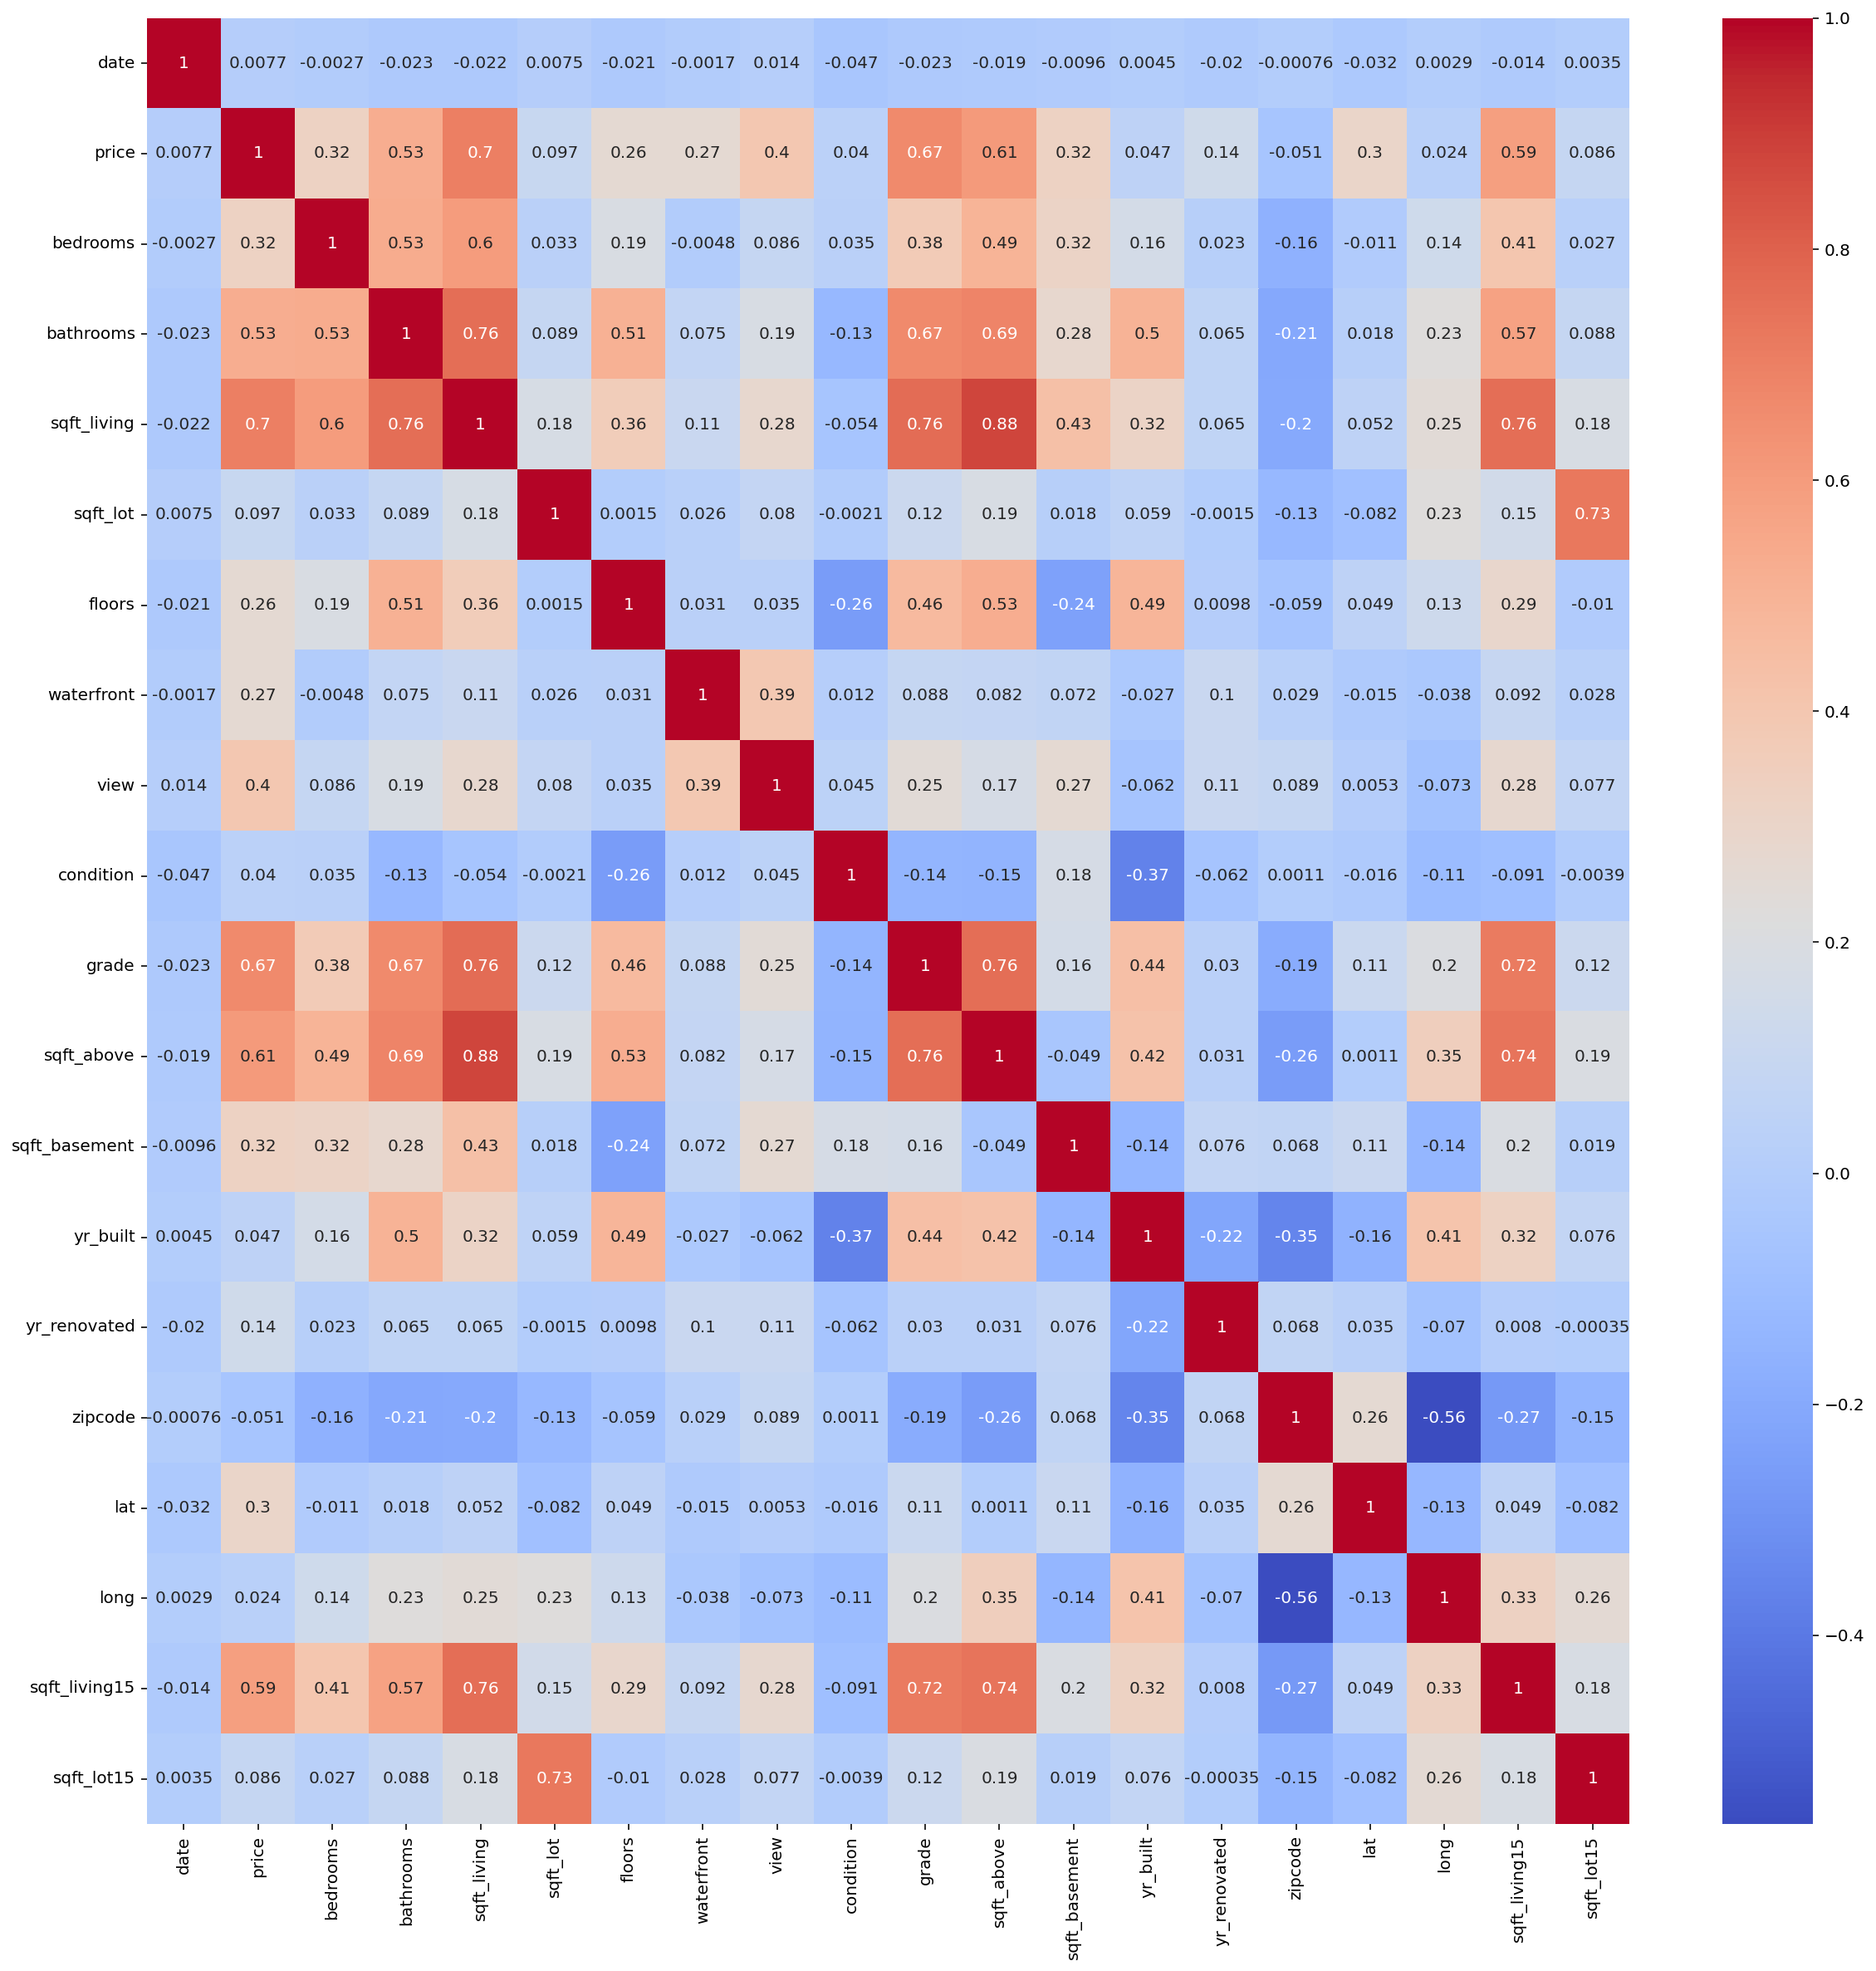

In [159]:
plt.figure(figsize=(20, 20))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.show()

■ price와의 상관계수값이 작은 date, zipcode 삭제하기

In [160]:
del train['date']
del train['zipcode']
print(train.columns)

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [161]:
del test['date']
del test['zipcode']
print(test.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


##### ■ 예측비교할 대상인 price를 train 데이터에서 잘라내고, y 에 따로 저장한다.

In [162]:
y = train['price']
del train['price']
print(train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [163]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       15035 non-null  int64  
 1   bathrooms      15035 non-null  float64
 2   sqft_living    15035 non-null  int64  
 3   sqft_lot       15035 non-null  int64  
 4   floors         15035 non-null  float64
 5   waterfront     15035 non-null  int64  
 6   view           15035 non-null  int64  
 7   condition      15035 non-null  int64  
 8   grade          15035 non-null  int64  
 9   sqft_above     15035 non-null  int64  
 10  sqft_basement  15035 non-null  int64  
 11  yr_built       15035 non-null  int64  
 12  yr_renovated   15035 non-null  int64  
 13  lat            15035 non-null  float64
 14  long           15035 non-null  float64
 15  sqft_living15  15035 non-null  int64  
 16  sqft_lot15     15035 non-null  int64  
dtypes: float64(4), int64(13)
memory usage: 2.0 MB


In [164]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       6468 non-null   int64  
 1   bathrooms      6468 non-null   float64
 2   sqft_living    6468 non-null   int64  
 3   sqft_lot       6468 non-null   int64  
 4   floors         6468 non-null   float64
 5   waterfront     6468 non-null   int64  
 6   view           6468 non-null   int64  
 7   condition      6468 non-null   int64  
 8   grade          6468 non-null   int64  
 9   sqft_above     6468 non-null   int64  
 10  sqft_basement  6468 non-null   int64  
 11  yr_built       6468 non-null   int64  
 12  yr_renovated   6468 non-null   int64  
 13  lat            6468 non-null   float64
 14  long           6468 non-null   float64
 15  sqft_living15  6468 non-null   int64  
 16  sqft_lot15     6468 non-null   int64  
dtypes: float64(4), int64(13)
memory usage: 859.2 KB


##### ■ price의 분포가 너무 몰려있어서, 넓게 퍼지고 크기를 보다 비슷해지게 만들기 위해, log(x+1)의 변환을 취한다. 

In [165]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

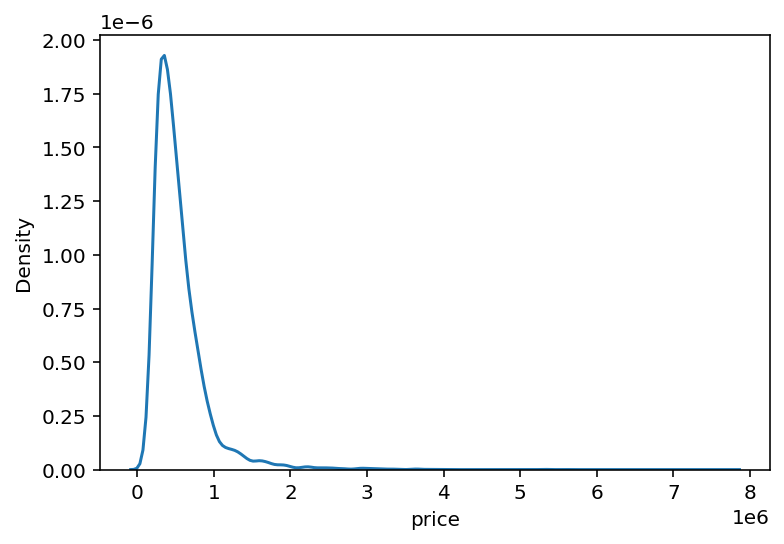

In [166]:
sns.kdeplot(y)
plt.show()

In [167]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

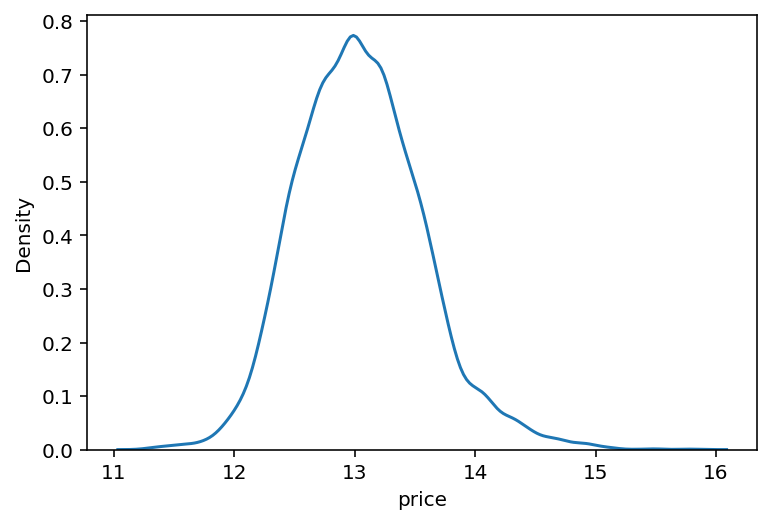

In [168]:
sns.kdeplot(y)
plt.show()

## 3. 모델정하고, 하이퍼파라미터 튜닝하기

### 3-1. grid search

##### ■ 함수만들기

In [170]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

##### ■ 파라미터 설정하기

In [171]:
param_grid = {
    'max_depth': [2, 10],                 # Tree의 최대 깊이
    'learning_rate': [0.0001, 0.1],       # learning rate
    'n_estimators': [20, 800],            # 사용하는 개별 모델의 개수
    'num_leaves': [4, 1023],              # 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
}

In [172]:
#random_state=None
random_state=2020
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
14,0.1000,10,800,4,-0.028741,0.169531
15,0.1000,10,800,1023,-0.029741,0.172455
10,0.1000,2,800,4,-0.030595,0.174914
11,0.1000,2,800,1023,-0.030595,0.174914
13,0.1000,10,20,1023,-0.036638,0.191411
12,0.1000,10,20,4,-0.078276,0.279778
8,0.1000,2,20,4,-0.081034,0.284665
9,0.1000,2,20,1023,-0.081034,0.284665
7,0.0001,10,800,1023,-0.243740,0.493700
6,0.0001,10,800,4,-0.255537,0.505507


## 4. 모델 학습하고, 예측결과 생성 후, 결과 저장하기

In [116]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    submission_path = 'https://raw.githubusercontent.com/twelvesense/first-repository/master/input/sample_submission.csv'
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    print(submission)
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format('./', model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [129]:
model = LGBMRegressor(learning_rate=0.1, max_depth=10, n_estimators=800, num_leaves=4, random_state=random_state)

In [130]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

         id         price
0     15035  5.501646e+05
1     15036  4.017071e+05
2     15037  1.407344e+06
3     15038  3.010031e+05
4     15039  3.160006e+05
...     ...           ...
6463  21498  2.546216e+05
6464  21499  4.103553e+05
6465  21500  4.493904e+05
6466  21501  3.112365e+05
6467  21502  4.224317e+05

[6468 rows x 2 columns]
.//submission_lgbm_RMSLE_0.0168.csv saved!


## 5. Kaggle 결과